# Image Classification Core
**Student:** Matthew Malueg

### Assignment Task

Our goal is to classify chest x-rays as 'normal', 'pneumonia', or 'covid' using Convolutional Neural Networks.

For this assignment, our goal is to get as high of an accuracy as possible, applying all of the techniques and tools covered this week.

### Imports, Functions

In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import visualkeras as vk

import keras_tuner as kt
from keras_tuner import HyperParameters as hp

import os

folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [2]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [3]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [4]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [5]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

### Making the TensorFlow Image Dataset

In [6]:
# Checking the contents of dataset folder
data_dir = "Data/xrays/"
data_dir

'Data/xrays/'

In [7]:
# Getting the list of folders in the data_dir
os.listdir(data_dir)

['covid', 'normal', 'pneumonia']

In [8]:
# Getting list of all img file paths
img_files = glob.glob(data_dir+"**/*")
len(img_files)

6939

In [9]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 96
img_width = 96

In [10]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 6903 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

216

**Saving Class Info**

In [12]:
# Save the class names for later use
class_names = ds.class_names
class_names

['covid', 'normal', 'pneumonia']

In [13]:
# Saving # of classes for later use
num_classes = len(class_names)
num_classes

3

In [14]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

**Train, Validation, Test Split**

In [15]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 151 batches as training data
Use 43 batches as validation data
The remaining 22 batches will be used as test data.


In [16]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
print(f'The training set is {len(train_ds)} batches long.')

The training set is 151 batches long.


In [17]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
print(f'The validation set is {len(val_ds)} batches long.')

The validation set is 43 batches long.


In [18]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
print(f'The testing set is {len(test_ds)} batches long.')

The testing set is 22 batches long.


### Optimize the Dataset

- Add a shuffle step to the training dataset.
- Add caching and prefetching to all 3 datasets.

In [19]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= len(train_ds),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Preview Data and Save the Shape

In [20]:
# Get image sizes for later use
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 96, 96, 3])

In [21]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([96, 96, 3])

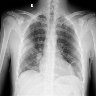

In [22]:
# Preview an image from the Dataset
array_to_img(example_batch_imgs[0])

In [23]:
# Show label value
label = class_dict[np.argmax(example_batch_y[0])]
label

'covid'

### Modeling

**Steps for every model**
- Fitting the model:
    - Using validation_data
    - Many epochs (20+)
    - An EarlyStopping callback
    - Save the training history
- Evaluating the model:
    - Plot the training history
    - Evaluate the model on the training and test data, including:
        - Scikit-learn confusion matrix
        - Scikit-learn classification report
        - The results from model.evaluate method
        - (Use custom flexible function)

#### 1) Build a Simple CNN Model

Tip: You may use the same baseline model from the "TensorFlow Dataset Objects" lesson.

In [24]:
# Get early stopping function that can be reused on all models
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [44]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(layers.Conv2D(filters=8, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # Convolutional layer
    model.add(layers.Conv2D(filters=8, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(3, activation="softmax")) 

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [26]:
# Build the model
model1 = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0

In [27]:
history = model1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=25,
    callbacks=get_callbacks(),
)

Epoch 1/25
151/151 [==============================] - 14s 60ms/step - loss: 0.6508 - accuracy: 0.7322 - val_loss: 0.5430 - val_accuracy: 0.8031
Epoch 2/25
151/151 [==============================] - 4s 26ms/step - loss: 0.4821 - accuracy: 0.8286 - val_loss: 0.4484 - val_accuracy: 0.8430
Epoch 3/25
151/151 [==============================] - 4s 27ms/step - loss: 0.3995 - accuracy: 0.8632 - val_loss: 0.4087 - val_accuracy: 0.8605
Epoch 4/25
151/151 [==============================] - 4s 27ms/step - loss: 0.3455 - accuracy: 0.8831 - val_loss: 0.3815 - val_accuracy: 0.8692
Epoch 5/25
151/151 [==============================] - 4s 27ms/step - loss: 0.3155 - accuracy: 0.8992 - val_loss: 0.3836 - val_accuracy: 0.8757
Epoch 6/25
151/151 [==============================] - 4s 27ms/step - loss: 0.3016 - accuracy: 0.8996 - val_loss: 0.3483 - val_accuracy: 0.8844
Epoch 7/25
151/151 [==============================] - 4s 27ms/step - loss: 0.2825 - accuracy: 0.9096 - val_loss: 0.3469 - val_accuracy: 0.889

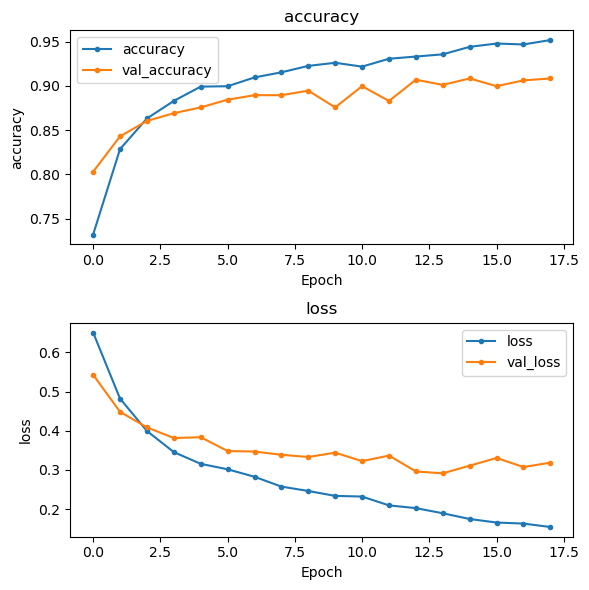


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1595
           1       0.92      0.97      0.95      1609
           2       0.97      0.94      0.95      1628

    accuracy                           0.96      4832
   macro avg       0.96      0.96      0.96      4832
weighted avg       0.96      0.96      0.96      4832



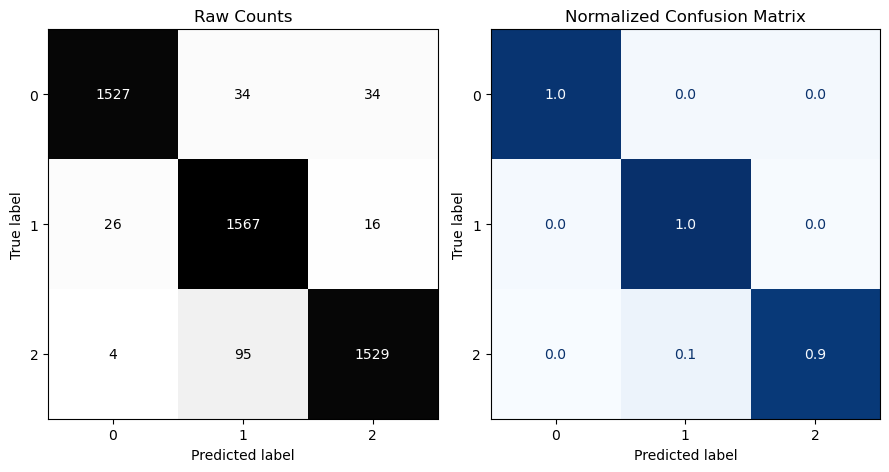


- Evaluating Training Data:
151/151 [==============================] - 1s 7ms/step - loss: 0.1345 - accuracy: 0.9567
{'loss': 0.1345028132200241, 'accuracy': 0.9567466974258423}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       209
           1       0.86      0.91      0.88       255
           2       0.91      0.89      0.90       231

    accuracy                           0.90       695
   macro avg       0.90      0.90      0.90       695
weighted avg       0.90      0.90      0.90       695



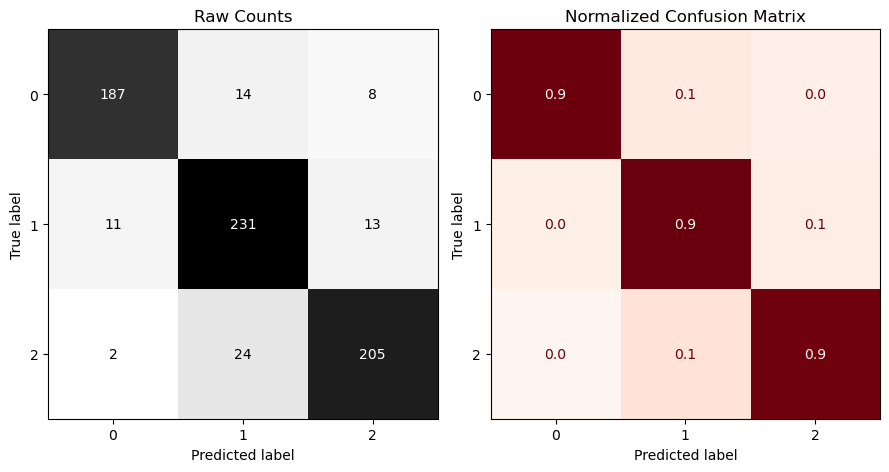


- Evaluating Test Data:
22/22 [==============================] - 0s 7ms/step - loss: 0.3540 - accuracy: 0.8964
{'loss': 0.35399067401885986, 'accuracy': 0.896402895450592}


In [28]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1,
                                X_train=train_ds,
                                X_test=test_ds,
                                figsize=(9,9),
                                values_format='0.1f',
                                history=history);

**Evaluation**
- The model reached 89% accuracy, which will be a good starting point for further optimization/tuning.
- To try and further increase performance, we will use a Dense layer, additional Conv2D layers, and try a higher number of filters.

#### 2) Build a more complex CNN Model

In [32]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer - additional filters
    model.add(layers.Conv2D(filters=16, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # Convolutional layer - additional Conv2D
    model.add(layers.Conv2D(filters=16, kernel_size=3, input_shape=input_shape, padding='same')) 
    model.add(layers.Conv2D(filters=16, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))

    # Hidden dense layer
    model.add(layers.Dense(32, activation="relu"))
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(3, activation="softmax")) 

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [33]:
# Build the model
model_2 = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        2320      
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                  

In [34]:
# Obtain and save history for examination
history_2 = model_2.fit(
    train_ds,
    validation_data = val_ds,
    epochs=25,
    callbacks=get_callbacks(),
)

Epoch 1/25
151/151 [==============================] - 7s 45ms/step - loss: 0.5268 - accuracy: 0.7939 - val_loss: 0.4466 - val_accuracy: 0.8423
Epoch 2/25
151/151 [==============================] - 8s 53ms/step - loss: 0.3440 - accuracy: 0.8847 - val_loss: 0.3488 - val_accuracy: 0.8721
Epoch 3/25
151/151 [==============================] - 8s 54ms/step - loss: 0.2629 - accuracy: 0.9143 - val_loss: 0.3310 - val_accuracy: 0.8895
Epoch 4/25
151/151 [==============================] - 8s 53ms/step - loss: 0.2299 - accuracy: 0.9251 - val_loss: 0.3236 - val_accuracy: 0.8953
Epoch 5/25
151/151 [==============================] - 8s 51ms/step - loss: 0.2056 - accuracy: 0.9263 - val_loss: 0.3414 - val_accuracy: 0.8895
Epoch 6/25
151/151 [==============================] - 8s 51ms/step - loss: 0.1784 - accuracy: 0.9394 - val_loss: 0.2946 - val_accuracy: 0.9113
Epoch 7/25
151/151 [==============================] - 8s 51ms/step - loss: 0.1435 - accuracy: 0.9514 - val_loss: 0.2865 - val_accuracy: 0.9062

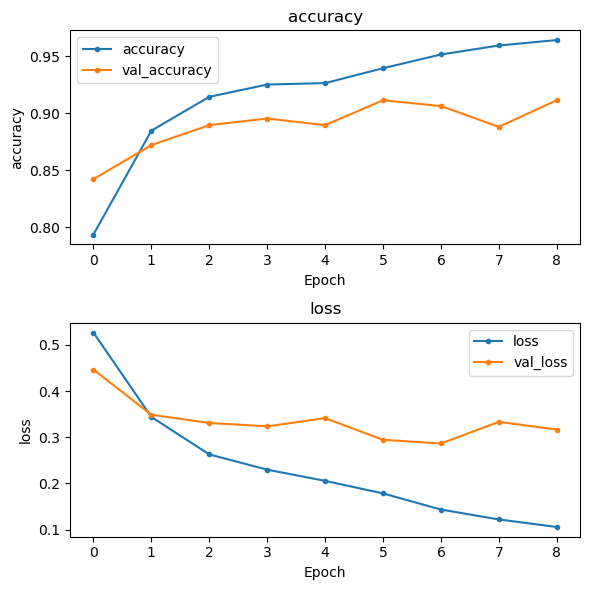


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1595
           1       0.92      0.99      0.96      1609
           2       1.00      0.93      0.96      1628

    accuracy                           0.97      4832
   macro avg       0.97      0.97      0.97      4832
weighted avg       0.97      0.97      0.97      4832



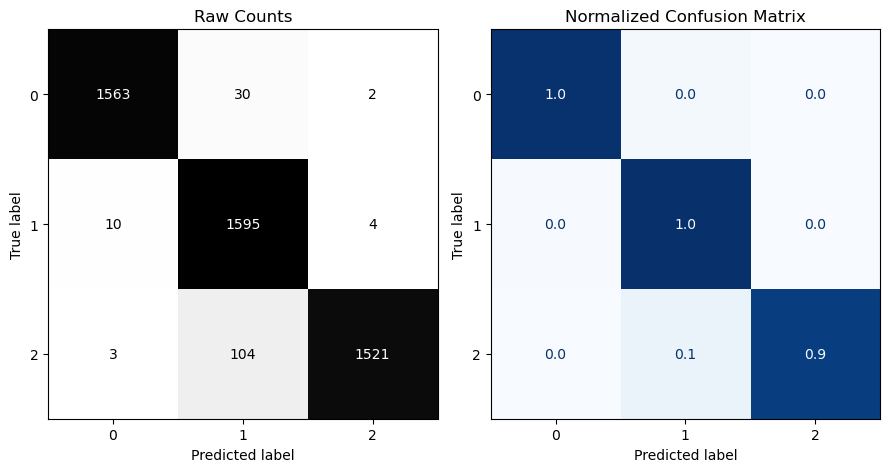


- Evaluating Training Data:
151/151 [==============================] - 2s 12ms/step - loss: 0.0955 - accuracy: 0.9683
{'loss': 0.09553971141576767, 'accuracy': 0.9683361053466797}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       209
           1       0.84      0.95      0.89       255
           2       0.97      0.86      0.91       231

    accuracy                           0.91       695
   macro avg       0.92      0.91      0.91       695
weighted avg       0.91      0.91      0.91       695



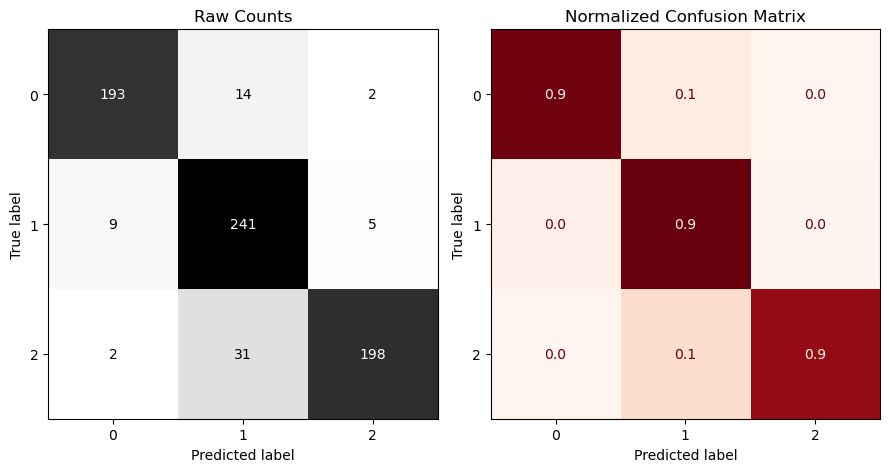


- Evaluating Test Data:
22/22 [==============================] - 0s 12ms/step - loss: 0.3956 - accuracy: 0.9094
{'loss': 0.3956485390663147, 'accuracy': 0.9093525409698486}


In [35]:
# Testing with the CNN + Dataset
evaluate_classification_network(model_2,
                                X_train=train_ds,
                                X_test=test_ds,
                                figsize=(9,9),
                                values_format='0.1f',
                                history=history_2);

**Evaluation**
- Our model has now gone to just over 91% accuracy, up from 89%. It seems the combined increase in filters, extra Conv2D, and dense layers helped the model slightly.

#### 3) Build a Transfer Learning Model using a Keras Application

87910968/87910968 [==============================] - 17s 0us/step


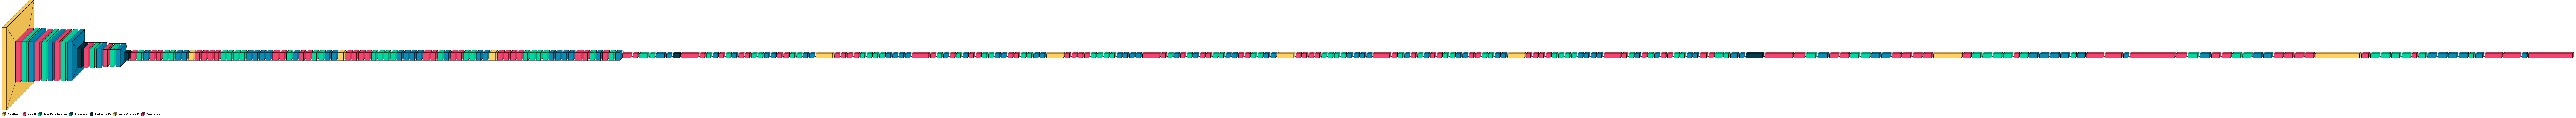

In [41]:
# Download base model
inception_base= tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape)

# Make it not trainable
inception_base.trainable=False
vk.layered_view(inception_base, legend=True)

In [42]:
# Add preprocessing lambda layer
lambda_layer_inception = tf.keras.layers.Lambda(tf.keras.applications.inception_v3.preprocess_input, 
                                      name='preprocess_input_inceptv3')


def build_inception_model():
    model = models.Sequential(name="InceptionV3")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_inception)

    # Add pretrained base
    model.add(inception_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input_inceptv3 (  (None, 96, 96, 3)        0         
 Lambda)                                                         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                       

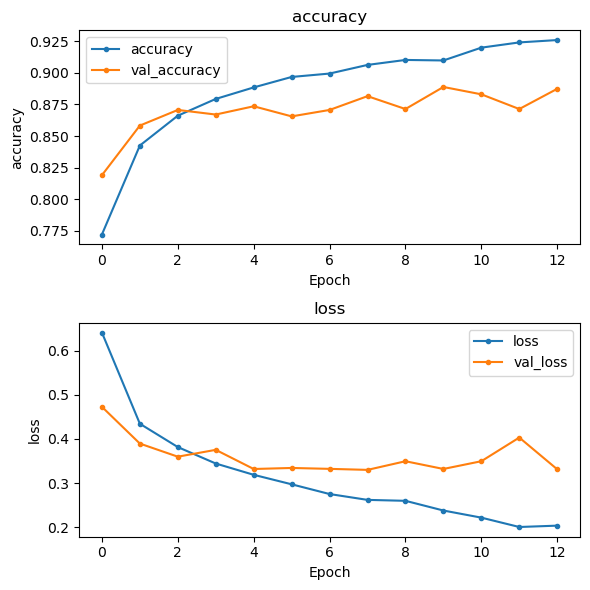


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       209
           1       0.84      0.94      0.88       255
           2       0.96      0.83      0.89       231

    accuracy                           0.89       695
   macro avg       0.90      0.89      0.90       695
weighted avg       0.90      0.89      0.90       695



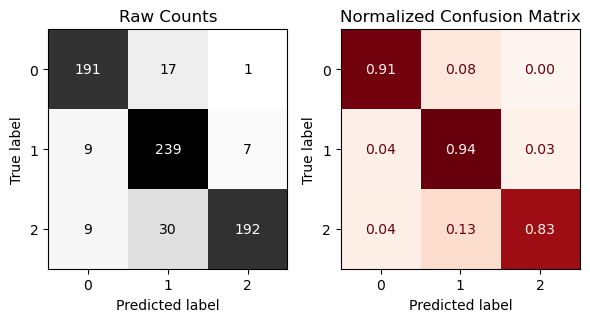


- Evaluating Test Data:
22/22 [==============================] - 2s 100ms/step - loss: 0.3468 - accuracy: 0.8950
{'loss': 0.3467662036418915, 'accuracy': 0.8949640393257141}


In [43]:
# Build, fit, and evaluate EfficientNet Model
model_inception = build_inception_model()
history = model_inception.fit(train_ds, validation_data=val_ds,epochs=20, 
                    callbacks=get_callbacks()
                   )
evaluate_classification_network(model_inception, X_test=test_ds, history=history);

### Choosing the Best Model

For the best model, I would go with InceptionV3. Accuracy was similar to the baseline and slightly below the adjusted model, but the loss score was better. While the first two models were slightly faster to get close to the same result, the Inception model looks like it may be overfitting less and may improve it's scores if allowed to run longer or with larger images/more data.

In [46]:
## Save the model for later use
# Select the best model
best_model = model_inception

In [47]:
# Make folder for model
import os
folder = 'BestModels/'
os.makedirs(folder, exist_ok=True)

In [48]:
# saving the best model
model_fname = 'BestModels/best_lung_clf_model.keras'
best_model.save(model_fname)